<a href="https://colab.research.google.com/github/jessiejzhou/math_156_final_project/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.environ["KAGGLE_USERNAME"] = "jessjzhou"
os.environ["KAGGLE_KEY"] = "8d9f8ef4b39ce556637c49f4b5204f0d"

!kaggle datasets download -d ananthu017/emotion-detection-fer
!unzip emotion-detection-fer.zip -d /content/

Dataset URL: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer
License(s): CC0-1.0
emotion-detection-fer.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  emotion-detection-fer.zip
replace /content/test/angry/im0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import seaborn as sns
import keras
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import warnings
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.simplefilter("ignore")
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import cv2
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import BatchNormalization


# Preprocessing

In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'


def create_dataframe_from_directory(directory):
    data = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)

        if os.path.isdir(label_path):
            for image_file in os.listdir(label_path):
                image_path = os.path.join(label_path, image_file)
                if image_file.endswith(('jpg', 'jpeg', 'png')):
                    data.append(image_path)
                    labels.append(label)

    df = pd.DataFrame({
        'image_path': data,
        'label': labels
    })

    return df

train_df = create_dataframe_from_directory(train_dir)
test_df = create_dataframe_from_directory(test_dir)

In [ ]:
#Comparing class sizes
train_df["label"].value_counts()

,count
label,
happy,7215
neutral,4965
sad,4830
fearful,4097
angry,3995
surprised,3171
disgusted,436


In [ ]:
remove_disgusted_train = np.where(train_df == 'disgusted')[0]
remove_disgusted_test = np.where(test_df == 'disgusted')[0]

train_df = np.delete(train_df, remove_disgusted_train, axis=0)
train_df = pd.DataFrame(train_df, columns = ["image_path", "label"])

test_df = np.delete(test_df, remove_disgusted_test, axis=0)
test_df = pd.DataFrame(test_df, columns = ["image_path", "label"])

In [ ]:
from tqdm import tqdm

def preprocess_image(image_path):

    img = cv2.imread(image_path)
    if img is None:
        return None
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized_img = cv2.resize(gray_img, (48, 48))
    return resized_img


train_df['processed_image'] = [
    preprocess_image(image_path) for image_path in tqdm(train_df['image_path'])
]
train_df = train_df[['processed_image', 'label']]


test_df['processed_image'] = [
    preprocess_image(image_path) for image_path in tqdm(test_df['image_path'])
]
test_df = test_df[['processed_image', 'label']]

100%|██████████| 7067/7067 [00:00<00:00, 11773.75it/s]


In [ ]:
# One hot encoding

X_train = np.stack(train_df['processed_image'].to_numpy())
X_test = np.stack(test_df['processed_image'].to_numpy())

X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_train = to_categorical(y_train)

y_test = label_encoder.fit_transform(test_df['label'])
y_test = to_categorical(y_test)

In [ ]:
labels = np.array(['angry', 'fearful', 'happy', 'neutral', 'sad','surprised'])
class_weights = compute_class_weight('balanced', classes = np.unique(labels), y = train_df['label'])
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
data = {
    "Emotion": ["happy", "sad", "angry", "disgusted", "neutral", "fearful", "surprised"],
    "Label (Integer Encoded)": [0, 1, 2, 3, 4, 5, 6],
    "Label (One-Hot Encoded)": [
        [1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1]
    ]
}

df_encoding = pd.DataFrame(data)

df_encoding

,Emotion,Label (Integer Encoded),Label (One-Hot Encoded)
0,happy,0,"[1, 0, 0, 0, 0, 0, 0]"
1,sad,1,"[0, 1, 0, 0, 0, 0, 0]"
2,angry,2,"[0, 0, 1, 0, 0, 0, 0]"
3,disgusted,3,"[0, 0, 0, 1, 0, 0, 0]"
4,neutral,4,"[0, 0, 0, 0, 1, 0, 0]"
5,fearful,5,"[0, 0, 0, 0, 0, 1, 0]"
6,surprised,6,"[0, 0, 0, 0, 0, 0, 1]"


#Model Building

The Sequential model is used because it allows us to stack layers one after another, which is a natural fit for most CNN architectures. Each layer feeds into the next in a straightforward manner. These are the components/paramters of our model:


Filters: these are the feature detectors, that can detect edges, textures, or patterns. More filters mean the network can learn more patterns. The first layer has less filters, and the second layer has double the amount filters to capture more complex features after the initial processing. we test 32 and 64.

Kernel Size: Specifies the size of the filter. A 3x3 filter is a standard choice that balances efficiency and feature extraction capability. 5x5 is more global and captures larger-scale patterns in the data.

activation='relu': ReLU (Rectified Linear Unit) introduces non-linearity, allowing the network to learn complex patterns.

input_shape=(48, 48, 1):
48x48: Image dimensions after preprocessing.
1: Number of channels (1 for grayscale images).

Pool Size: A 2x2 pooling operation reduces each dimension by half, which reduces computational load and helps prevent overfitting by reducing detail.

Dropout: Prevent overfitting by randomly "dropping out" (setting to 0) a fraction of the neurons during training. We test 10% and 25% dropout.

Flatten: Converts the 2D feature maps into a 1D vector, which can be fed into dense layers. Without flattening, the dense layer wouldn’t be able to process the data.

First Dense Layer: connected every neuron in the layer to toe previous layer. We test having 128 and 256 neurons in this layer.

Output Dense Layer: This combines the extracted features to make a final decision about the class. y_train.shape[1] is the number of neurons equal to the number of classes. Then, we use activation='softmax': to convert outputs into probabilities, one for each class.


Loss Function: Since this is multi-class classification, we use categorical_crossentropy (used with one-hot encoded labels). This is the difference between the predicted probabilities and the actual labels.

In [ ]:
def build_model(filters, kernel_size, dense_neurons, dropout):
  model = Sequential([
      Conv2D(filters, kernel_size, activation = 'relu', input_shape=(48,48,1)),
      BatchNormalization(),
      MaxPooling2D((2,2)),
      Dropout(dropout),

      Conv2D(2 * filters, kernel_size, activation = 'relu'),
      BatchNormalization(),
      MaxPooling2D((2,2)),
      Dropout(dropout),

      Flatten(),
      Dense(dense_neurons, activation='relu'),
      BatchNormalization(),
      Dropout(dropout),
      Dense(y_train.shape[1], activation='softmax')  # Output layer
  ])
  model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
  return model

hyperparameters = {
      'filters': [32, 64],
      'kernel_size': [(3,3), (5,5)],
      'dense_neurons': [128, 256],
      'dropout': [0.1, 0.25]
  }

# Cross-validation

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=1)

In [ ]:
from itertools import product

hyperparameter_combos = list(product(
    hyperparameters['filters'],
    hyperparameters['kernel_size'],
    hyperparameters['dense_neurons'],
    hyperparameters['dropout']
))

results = []

for filters, kernel_size, dense_neurons, dropout in hyperparameter_combos:
  fold_accuracies = []
  print(f"Testing hyperparameters: filters={filters}, kernel_size={kernel_size}, dense_neurons={dense_neurons}, dropout={dropout}")

  for train_index, val_index in kfold.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model = build_model(filters, kernel_size, dense_neurons, dropout)
    history = model.fit(X_train_fold,
                        y_train_fold,
                        validation_data=(X_val_fold, y_val_fold),
                        epochs=10,
                        batch_size=32,
                        verbose=1,
                        class_weight = class_weights_dict)

    val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)[1]
    fold_accuracies.append(val_accuracy)

  avg_accuracy = np.mean(fold_accuracies)
  print(f"Average accuracy for this combination: {avg_accuracy}")

  results.append((filters, kernel_size, dense_neurons, dropout, avg_accuracy))


Testing hyperparameters: filters=32, kernel_size=(3, 3), dense_neurons=128, dropout=0.1
Epoch 1/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.3308 - loss: 1.7761 - val_accuracy: 0.3498 - val_loss: 1.6571
Epoch 2/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4775 - loss: 1.3409 - val_accuracy: 0.4538 - val_loss: 1.4356
Epoch 3/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5344 - loss: 1.2035 - val_accuracy: 0.4566 - val_loss: 1.3995
Epoch 4/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5768 - loss: 1.1094 - val_accuracy: 0.4884 - val_loss: 1.3267
Epoch 5/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6102 - loss: 1.0287 - val_accuracy: 0.5273 - val_loss: 1.2967
Epoch 6/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6572 - loss: 0.9181 - val_accuracy: 0.4803 - val_loss: 1.4064
Epoch 7/10
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6958 - loss: 0.8266 - val_accuracy: 0.2027 - val_loss: 5.5122
Epoch 8/10
707

In [ ]:
results

[(32, (3, 3), 128, 0.1, 0.5259089469909668),
 (32, (3, 3), 128, 0.25, 0.5212402522563935),
 (32, (3, 3), 256, 0.1, 0.5122923135757447),
 (32, (3, 3), 256, 0.25, 0.4312282681465149),
 (32, (5, 5), 128, 0.1, 0.5276416540145874),
 (32, (5, 5), 128, 0.25, 0.521699070930481),
 (32, (5, 5), 256, 0.1, 0.5167101919651031),
 (32, (5, 5), 256, 0.25, 0.4847744286060333),
 (64, (3, 3), 128, 0.1, 0.5235738754272461),
 (64, (3, 3), 128, 0.25, 0.5345025300979614),
 (64, (3, 3), 256, 0.1, 0.49241588115692136),
 (64, (3, 3), 256, 0.25, 0.483955180644989),
 (64, (5, 5), 128, 0.1, 0.5176322221755981),
 (64, (5, 5), 128, 0.25, 0.5374030709266663),
 (64, (5, 5), 256, 0.1, 0.5013590753078461),
 (64, (5, 5), 256, 0.25, 0.5189415693283081)]

## Saving results

In [ ]:
import pickle

with open('/content/drive/My Drive/cv_results.pkl', 'wb') as f:
  pickle.dump(results, f)


In [ ]:
with open('/content/drive/My Drive/cv_results.pkl', 'rb') as file:
    data = pickle.load(file)

# Display the loaded object
data

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/cv_results.pkl'

## Final Model

**Note:** From observing the cross-validation, we saw some gaps between validation and testing loss/accuaracy. Thus we decided to add L2 regularization here to prevent overfitting.

In [ ]:
from tensorflow.keras import regularizers

reg_model = Sequential([
      Conv2D(64, (3,3), activation = 'relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(48,48,1)),
      BatchNormalization(),
      MaxPooling2D((2,2)),
      Dropout(0.25),

      Conv2D(2 * 64, (3,3), activation = 'relu', kernel_regularizer=regularizers.l2(0.01)),
      BatchNormalization(),
      MaxPooling2D((2,2)),
      Dropout(0.25),

      Flatten(),
      Dense(128, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)),
      BatchNormalization(),
      Dropout(0.25),
      Dense(y_train.shape[1], activation='softmax')  # Output layer
  ])
reg_model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])


X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train.argmax(axis=1), random_state=1
)

In [ ]:
history = reg_model.fit(X_train_split,
                      y_train_split,
                      validation_data=(X_val_split, y_val_split),
                      epochs=75,
                      batch_size=32,
                      verbose=1,
                      class_weight = class_weights_dict)

Epoch 1/75
707/707 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.4208 - loss: 2.2961 - val_accuracy: 0.2322 - val_loss: 2.6037
Epoch 2/75
707/707 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4414 - loss: 2.2135 - val_accuracy: 0.4046 - val_loss: 2.3685
Epoch 3/75
707/707 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4397 - loss: 2.2773 - val_accuracy: 0.4113 - val_loss: 2.2358
Epoch 4/75
707/707 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4503 - loss: 2.1506 - val_accuracy: 0.4433 - val_loss: 2.1375
Epoch 5/75
707/707 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4568 - loss: 2.1300 - val_accuracy: 0.4018 - val_loss: 2.1838
Epoch 6/75
707/707 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4544 - loss: 2.1157 - val_accuracy: 0.2651 - val_loss: 2.7579
Epoch 7/75
707/707 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4602 - loss: 2.0769 - val_accuracy: 0.3959 - val_loss: 2.1163
Epoch 8/75
707/707 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4629 - loss: 2.0383 - val_accuracy: 0

# Results and Analysis

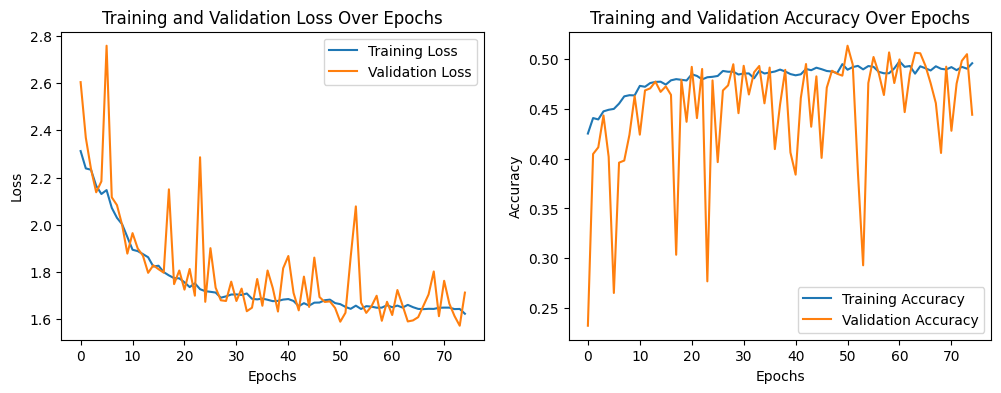

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label to Integer Mapping:", label_mapping)


Label to Integer Mapping: {'angry': 0, 'fearful': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprised': 5}


221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


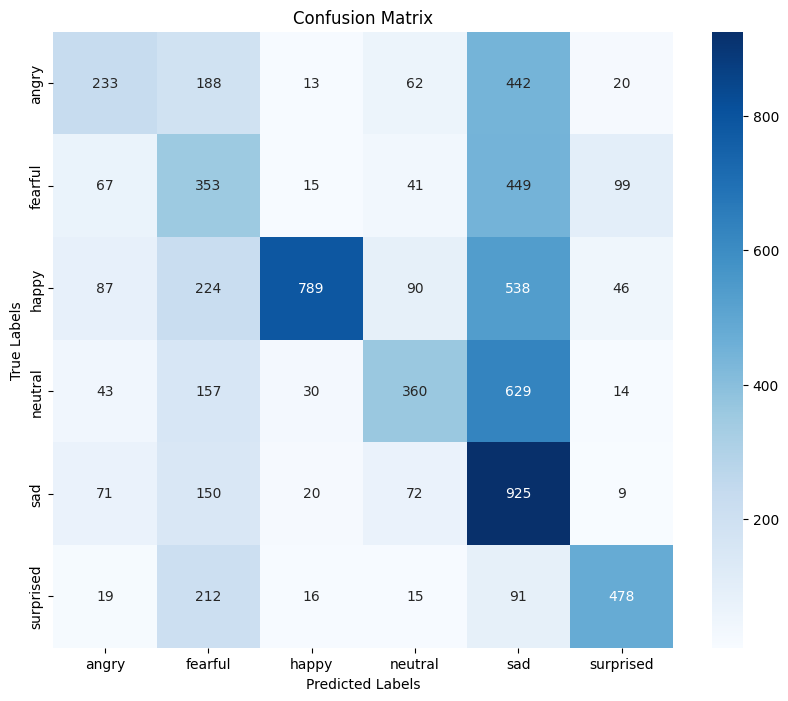

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


y_pred_probs = reg_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

class_names = ['angry', 'fearful', 'happy', 'neutral', 'sad','surprised']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#Final Model test accuracy
loss, accuracy = reg_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4346 - loss: 1.7291
Test Accuracy: 44.40%
